This script is a simple approach to building multi armed bandit. The problem was inspired by the 2020 Christmas Kaggle competition where two teams of elfs would have to collect as many candy canes as possible from vending machines. The team with the most candy win.

### Prerequisites and Imports

In [3]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define function to visualise agent/elf's interaction with the machines
def plot_history(history):
    rewards = history['rewards']
    avg_rewards = history['avg_rewards']
    chosen_machines = history['machines']
    
    fig = plt.figure(figsize=[20,6])
    
    line = fig.add_subplot(1,2,1)
    line.plot(avg_rewards, color='C3', label='avg rewards')
    line.set_title('Average Rewards')
    
    bchart = fig.add_subplot(1,2,2)
    bchart.bar([i for i in range(len(chosen_machines))], chosen_machines, color='C3', label='chosen machines')
    bchart.set_title('Chosen Actions')

### Create the environment

In [4]:
# create a class for the environment that contains the probability to get a reward and the actual rewards
class Env(object):
    def __init__(self, prob_reward, rewards):
        if len(prob_reward) != len(rewards): 
            raise Exception(f'size of reward probability: {len(prob_reward)} does not does match size of rewards: {len(rewards)}')
        
        # pass arguments to the environment
        self.prob_reward = prob_reward
        self.rewards = rewards
        self.k_machines = len(rewards)
        
    # define function to specify the machine the elf is going to use 
    def choose_machine(self, machine):
        if machine < 0 or machine > self.k_machines:
            raise Exception(f'machine must be a value between 0 and {self.k_machines -1}') # -1 because 0 counts as a number
        return self.rewards[machine] if np.random.random() < self.prob_reward[machine] else 0.0

In [5]:
# create environment
environment = Env(prob_reward=[0.01, 0.05, 0.20, 0.50, 0.65, 0.90], 
                  rewards=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# print the reward probabilities
print(f'Reward Probabilities: {environment.prob_reward}')
print(f'Reward: {environment.rewards}')

Reward Probabilities: [0.01, 0.05, 0.2, 0.5, 0.65, 0.9]
Reward: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [6]:
# use a machine
[environment.choose_machine(0) for _ in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Create a base line agent

In [7]:
# create random agent
class RandomAgent(object):
    def __init__(self, env, max_iterations=2000):
        self.env = env 
        self.iterations = max_iterations 
        
    # let the agent take actions in the environment
    def action(self):
        # keep track of the rewards the agent generates and which machine it is using
        machine_counts = np.zeros(self.env.k_machines)
        
        # store the reward the agent is generating
        rewards= []
        # store reward the agent is generating over time
        avg_rewards = []
        
        for i in range(1, self.iterations+1):
            machine = np.random.choice(self.env.k_machines)
            reward = self.env.choose_machine(machine)
            
            # increasing the machine count to know how many time the machine has been used
            machine_counts[machine] += 1 
            
            # append the results to the list rewards and avg_rewards
            rewards.append(reward)
            avg_rewards.append(sum(rewards)/len(rewards))
            
        # create a dictionary with the results to use our plotting function
        return {'machines': machine_counts,
                'rewards': rewards,
                'avg_rewards': avg_rewards
               }

In [8]:
# create the instance
random_agent = RandomAgent(env=environment, max_iterations=2000)

# action the agent is taking
ra_history= random_agent.action()

# print
print(f'total reward : {sum(ra_history["rewards"])}')

total reward : 769.0


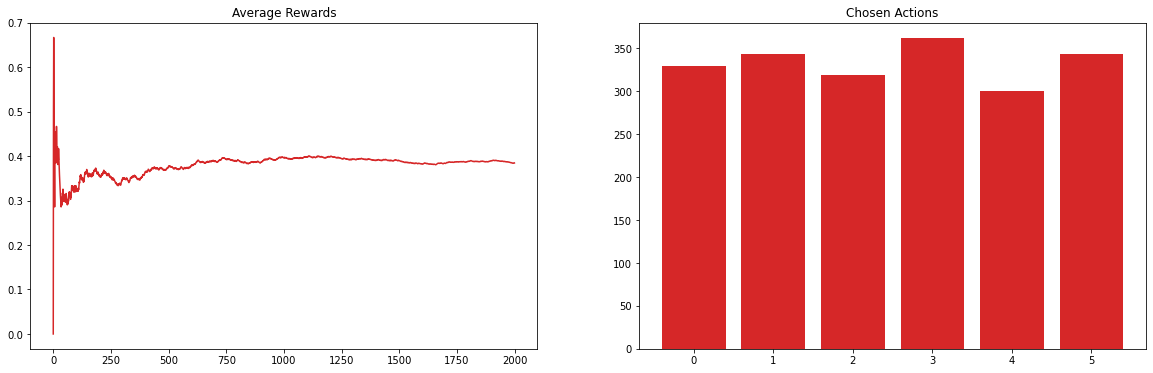

In [9]:
# plot the history
plot_history(ra_history)

### Create 'intelligent' agents

In [10]:
# create epsilon greedy agent
class EpsilonGreedyAgent(object):
    def __init__(self, env, max_iterations=2000, epsilon=0.01):
        self.env = env 
        self.iterations = max_iterations
        self.epsilon = epsilon
        
    # let the agent take actions in the environment
    def action(self):
        # initialise the q_values
        q_values = np.zeros(self.env.k_machines)
        # keep track of total reward generated by each machine
        machine_rewards = np.zeros(self.env.k_machines)
        # keep track of the rewards the agent generates and which machine it is using
        machine_counts = np.zeros(self.env.k_machines)
        
        # store the reward the agent is generating
        rewards= []
        # store reward the agent is generating over time
        avg_rewards = []
        
        for i in range(1, self.iterations+1):
            machine = np.random.choice(self.env.k_machines) if np.random.random() < self.epsilon else np.argmax(q_values)
            
            # store information
            reward = self.env.choose_machine(machine)
            machine_rewards[machine] += reward 
            machine_counts[machine] += 1
            q_values[machine] = machine_rewards[machine]/machine_counts[machine]
        
            # append the results to the list rewards and avg_rewards
            rewards.append(reward)
            avg_rewards.append(sum(rewards)/len(rewards))
            
        # create a dictionary with the results to use our plotting function
        return {'machines': machine_counts,
                'rewards': rewards,
                'avg_rewards': avg_rewards
               }

In [11]:
# create an instance of the epsilon greedy agent
egreedy_agent = EpsilonGreedyAgent(env=environment, max_iterations=2000, epsilon=0.1)
eg_history = egreedy_agent.action()

# print
print(f'total reward : {sum(eg_history["rewards"])}')

total reward : 1639.0


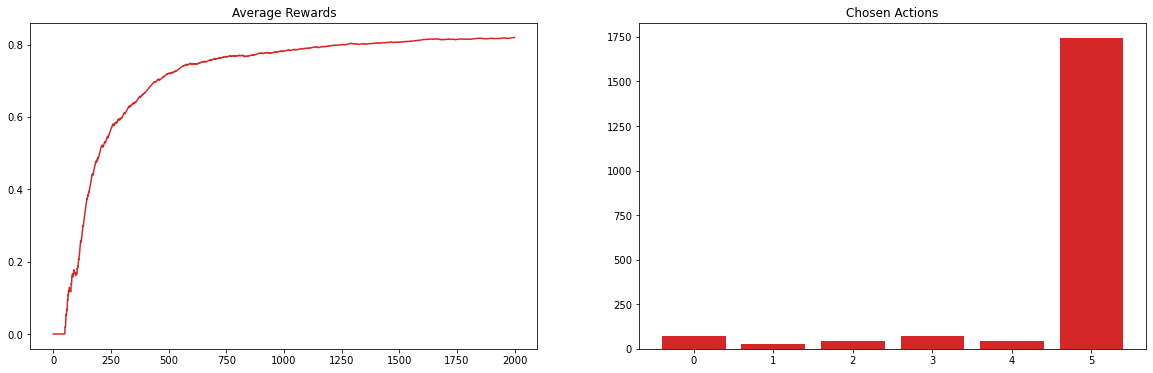

In [12]:
plot_history(eg_history)

In [19]:
# create epsilon greedy agent with decay
class EpsilonGreedyDecayAgent(object):
    def __init__(self, env, max_iterations=2000, epsilon=0.01, decay=0.001, decay_interval=50):
        self.env = env 
        self.iterations = max_iterations
        self.epsilon = epsilon
        self.decay = decay
        self.decay_interval = decay_interval
        
    # let the agent take actions in the environment
    def action(self):
        # initialise the q_values
        q_values = np.zeros(self.env.k_machines)
        # keep track of total reward generated by each machine
        machine_rewards = np.zeros(self.env.k_machines)
        # keep track of the rewards the agent generates and which machine it is using
        machine_counts = np.zeros(self.env.k_machines)
        
        # store the reward the agent is generating
        rewards= []
        # store reward the agent is generating over time
        avg_rewards = []
        
        for i in range(1, self.iterations+1):
            machine = np.random.choice(self.env.k_machines) if np.random.random() < self.epsilon else np.argmax(q_values)
            
            # store information
            reward = self.env.choose_machine(machine)
            machine_rewards[machine] += reward 
            machine_counts[machine] += 1
            q_values[machine] = machine_rewards[machine]/machine_counts[machine]
        
            # append the results to the list rewards and avg_rewards
            rewards.append(reward)
            avg_rewards.append(sum(rewards)/len(rewards))
            
            # if statement for the decay of epsilon at interval step time
            if i%self.decay_interval == 0:
              self.epsilon = self.epsilon * self.decay
              
        # create a dictionary with the results to use our plotting function
        return {'machines': machine_counts,
                'rewards': rewards,
                'avg_rewards': avg_rewards
               }

total reward : 1781.0


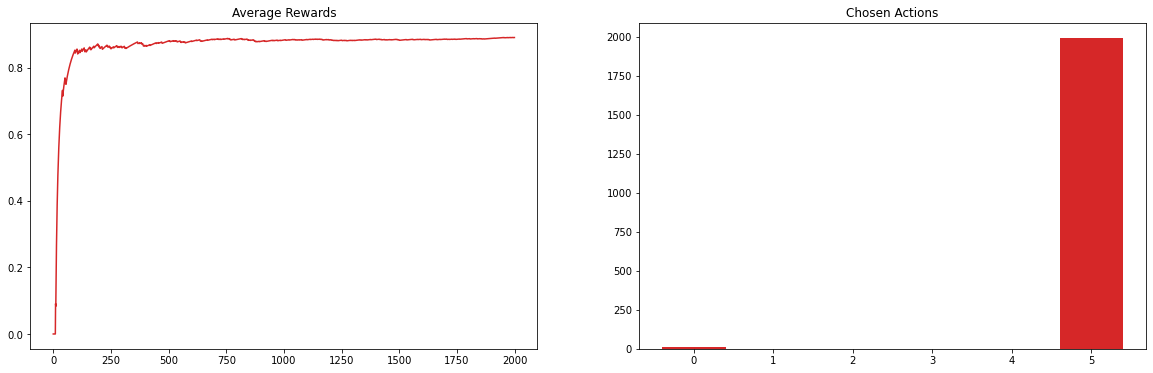

In [16]:
# create an instance of the epsilon greedy agent with decay
egreedyd_agent = EpsilonGreedyDecayAgent(env=environment, max_iterations=2000, epsilon=0.01, decay=0.001, decay_interval= 50)
egd_history = egreedyd_agent.action()

# print total rewards and charts
print(f'total reward : {sum(egd_history["rewards"])}')
plot_history(egd_history)